In [1]:
import os
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Dataset directories
train_dir = r"G:\My Drive\Fanshawe\PyTorch\garbage_dataset_split\train"
val_dir = r"G:\My Drive\Fanshawe\PyTorch\garbage_dataset_split\val"
test_dir = r"G:\My Drive\Fanshawe\PyTorch\garbage_dataset_split\test"

# Data augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)


Using device: cuda
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [3]:
# Phase 1: Feature Extraction from ResNet-50 model
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Replace FC layer
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

# Training loop with Early Stopping
num_epochs = 30
patience = 5
best_val_acc = 0.0
patience_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss, running_corrects = 0.0, 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)

            # Early stopping
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                patience_counter = 0
                print('** New best model saved! **')
            else:
                patience_counter += 1
                print(f'No improvement. Patience {patience_counter}/{patience}')
                if patience_counter >= patience:
                    print('Early stopping triggered!')
                    model.load_state_dict(best_model_wts)
                    break
    else:
        continue
    break

# Load best feature extraction weights
model.load_state_dict(best_model_wts)


D:\myVE\env_PyTorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\myVE\env_PyTorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
** New best model saved! **
Epoch 2/30
** New best model saved! **
Epoch 3/30
** New best model saved! **
Epoch 4/30
No improvement. Patience 1/5
Epoch 5/30
** New best model saved! **
Epoch 6/30
No improvement. Patience 1/5
Epoch 7/30
** New best model saved! **
Epoch 8/30
No improvement. Patience 1/5
Epoch 9/30
No improvement. Patience 2/5
Epoch 10/30
** New best model saved! **
Epoch 11/30
** New best model saved! **
Epoch 12/30
** New best model saved! **
Epoch 13/30
No improvement. Patience 1/5
Epoch 14/30
** New best model saved! **
Epoch 15/30
No improvement. Patience 1/5
Epoch 16/30
** New best model saved! **
Epoch 17/30
No improvement. Patience 1/5
Epoch 18/30
No improvement. Patience 2/5
Epoch 19/30
No improvement. Patience 3/5
Epoch 20/30
No improvement. Patience 4/5
Epoch 21/30
No improvement. Patience 5/5
Early stopping triggered!


<All keys matched successfully>

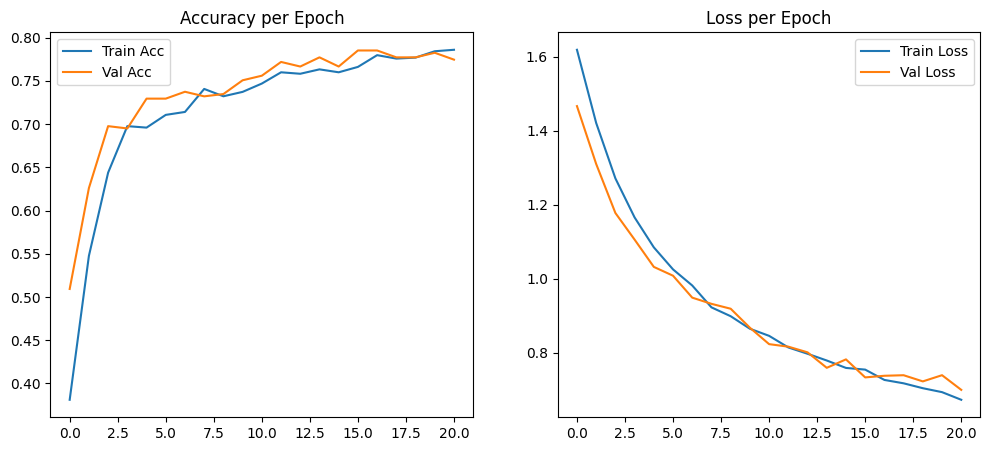

In [4]:
# Convert tensor histories to numpy for plotting purpose
train_acc_np = [x.cpu().numpy() if torch.is_tensor(x) else x for x in train_acc_history]
val_acc_np = [x.cpu().numpy() if torch.is_tensor(x) else x for x in val_acc_history]
train_loss_np = [x.cpu().numpy() if torch.is_tensor(x) else x for x in train_loss_history]
val_loss_np = [x.cpu().numpy() if torch.is_tensor(x) else x for x in val_loss_history]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_acc_np, label='Train Acc')
plt.plot(val_acc_np, label='Val Acc')
plt.legend(); plt.title('Accuracy per Epoch')

plt.subplot(1,2,2)
plt.plot(train_loss_np, label='Train Loss')
plt.plot(val_loss_np, label='Val Loss')
plt.legend(); plt.title('Loss per Epoch')
plt.show()


In [5]:
# Phase 2: Fine-Tuning
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

num_finetune_epochs = 10
patience = 3

best_ft_model_wts = copy.deepcopy(model.state_dict())
best_ft_acc = 0.0
patience_counter = 0

for epoch in range(num_finetune_epochs):
    print(f"\nFine-Tune Epoch {epoch+1}/{num_finetune_epochs}")
    model.train()
    running_loss, running_corrects = 0.0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_ft.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_ft.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Validation
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)
    print(f"Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_ft_acc:
        best_ft_acc = val_acc
        best_ft_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
        print(f"** New Best Val Acc: {best_ft_acc:.4f} **")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered for fine-tuning.")
            break

model.load_state_dict(best_ft_model_wts)
torch.save(best_ft_model_wts, "best_garbage_model.pth")
print("*** Fine-tuning complete. Best Val Acc:", best_ft_acc)



Fine-Tune Epoch 1/10
Train Acc: 0.7950, Val Acc: 0.8170
** New Best Val Acc: 0.8170 **

Fine-Tune Epoch 2/10
Train Acc: 0.8233, Val Acc: 0.8408
** New Best Val Acc: 0.8408 **

Fine-Tune Epoch 3/10
Train Acc: 0.8562, Val Acc: 0.8488
** New Best Val Acc: 0.8488 **

Fine-Tune Epoch 4/10
Train Acc: 0.8715, Val Acc: 0.8674
** New Best Val Acc: 0.8674 **

Fine-Tune Epoch 5/10
Train Acc: 0.8749, Val Acc: 0.8647

Fine-Tune Epoch 6/10
Train Acc: 0.9026, Val Acc: 0.8700
** New Best Val Acc: 0.8700 **

Fine-Tune Epoch 7/10
Train Acc: 0.9037, Val Acc: 0.8727
** New Best Val Acc: 0.8727 **

Fine-Tune Epoch 8/10
Train Acc: 0.9230, Val Acc: 0.8886
** New Best Val Acc: 0.8886 **

Fine-Tune Epoch 9/10
Train Acc: 0.9315, Val Acc: 0.8753

Fine-Tune Epoch 10/10
Train Acc: 0.9451, Val Acc: 0.8939
** New Best Val Acc: 0.8939 **
*** Fine-tuning complete. Best Val Acc: tensor(0.8939, device='cuda:0', dtype=torch.float64)



 Final Test Accuracy: 0.8672

              precision    recall  f1-score   support

   cardboard       0.95      0.90      0.92        61
       glass       0.86      0.86      0.86        76
       metal       0.83      0.87      0.85        62
       paper       0.91      0.83      0.87        90
     plastic       0.81      0.88      0.84        73
       trash       0.83      0.91      0.87        22

    accuracy                           0.87       384
   macro avg       0.87      0.87      0.87       384
weighted avg       0.87      0.87      0.87       384



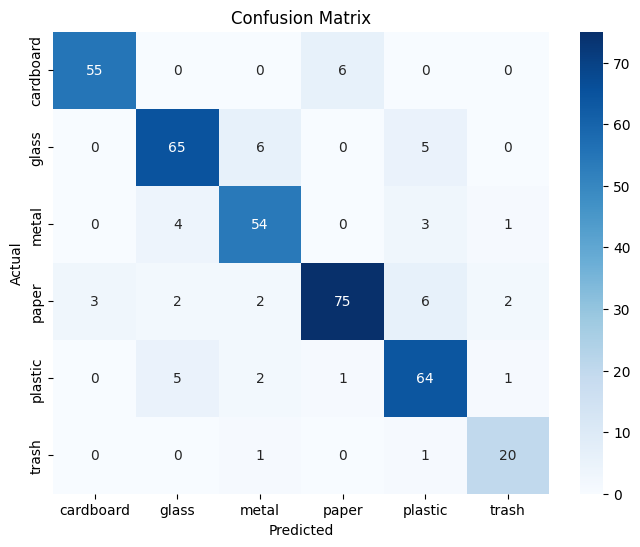

In [6]:
# Evaluation
model.eval()
test_corrects = 0
all_preds, all_labels, misclassified = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        test_corrects += torch.sum(preds == labels)

        for i in range(inputs.size(0)):
            if preds[i] != labels[i]:
                misclassified.append((inputs[i].cpu(), preds[i].cpu(), labels[i].cpu()))

test_acc = test_corrects.double() / len(test_loader.dataset)
print(f"\n Final Test Accuracy: {test_acc:.4f}\n")

print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()



🔍 Showing 12 Misclassified Images:


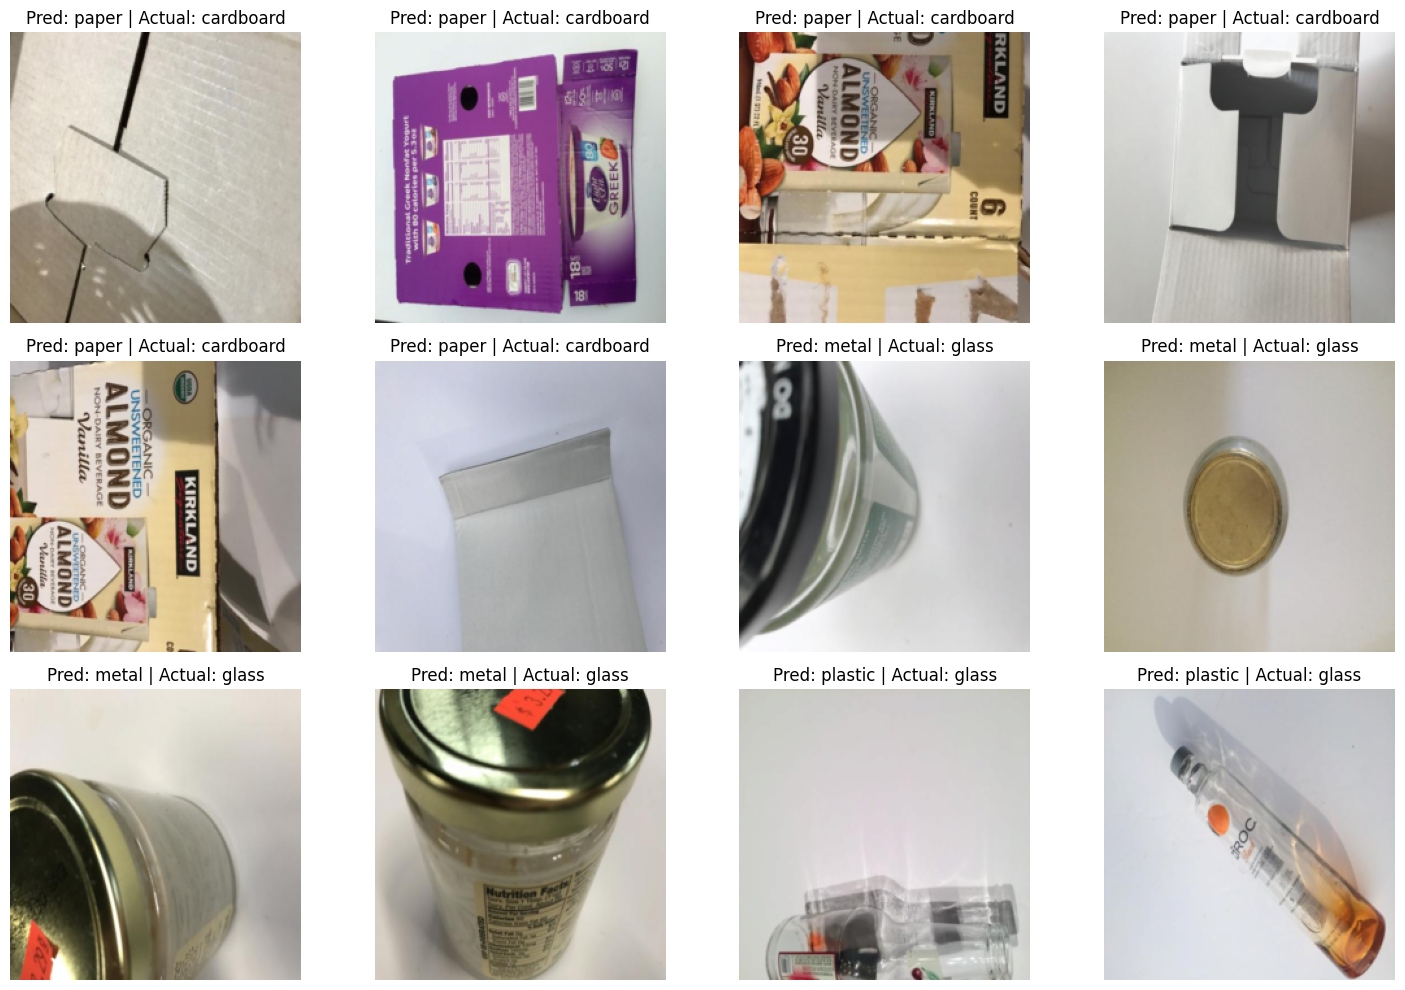

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

print(f"\n🔍 Showing {min(12, len(misclassified))} Misclassified Images:")
plt.figure(figsize=(15, 10))
for idx, (img, pred, actual) in enumerate(misclassified[:12]):
    plt.subplot(3, 4, idx+1)
    imshow(img, title=f"Pred: {class_names[pred]} | Actual: {class_names[actual]}")
plt.tight_layout()
plt.show()


✅ Model loaded from: best_garbage_model.pth


Text(0.5, 0.98, 'Garbage Classification - Inference with Top-3 Confidence')

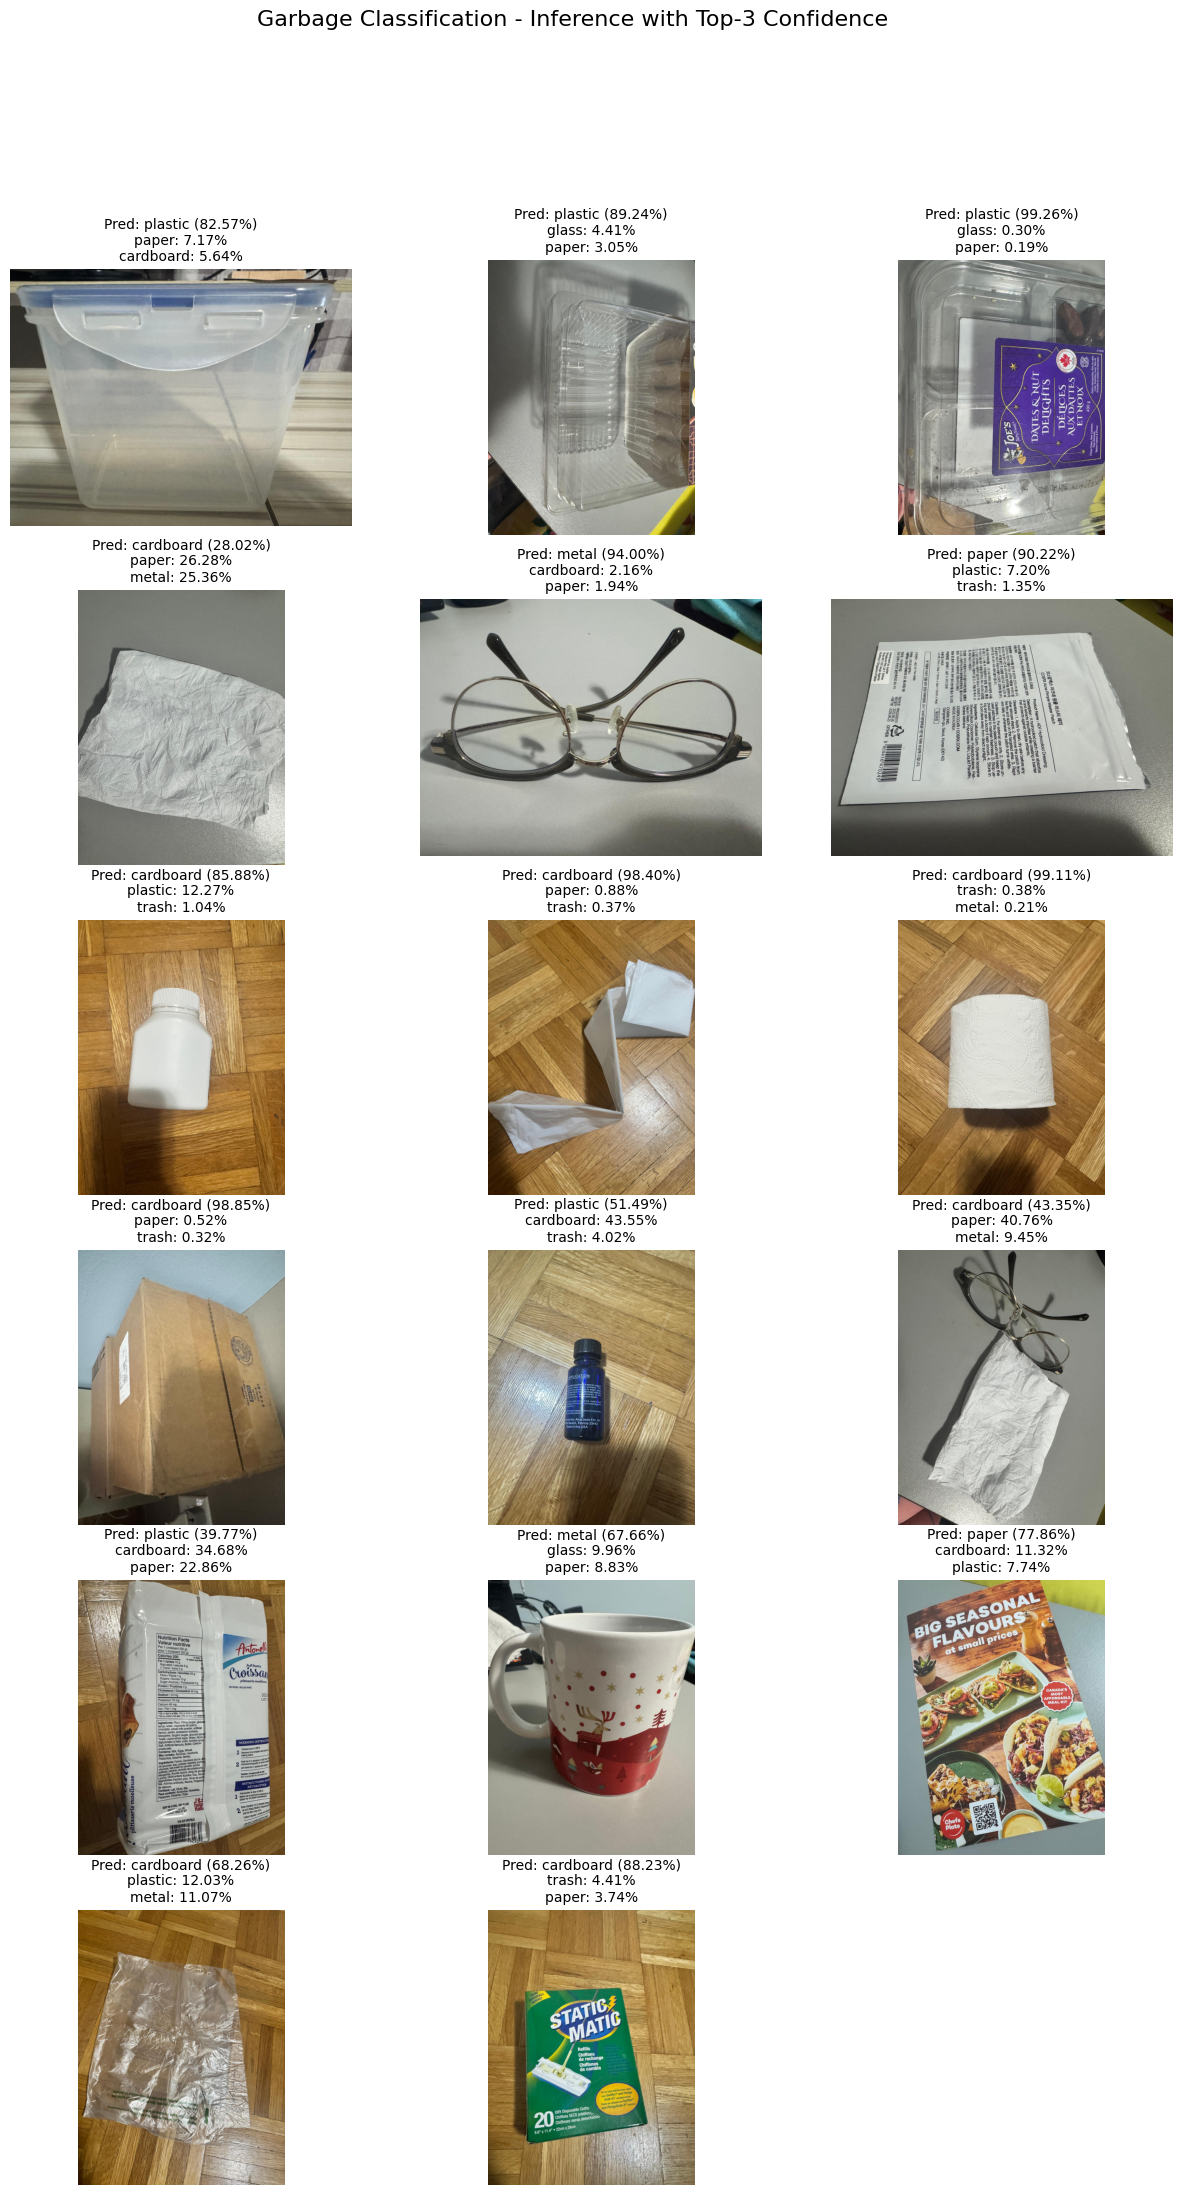

In [8]:
# Load the Best Model & Run Inference on New Images (with Top-K Confidence)

# 1. Load the saved best model weights
model_load_path = "best_garbage_model.pth"

model.load_state_dict(torch.load(model_load_path, map_location=device))
model.to(device)
model.eval()
print(f"✅ Model loaded from: {model_load_path}")

# 2. Define image preprocessing
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

# 3. function for prediction with Top-K confidence
def predict_image(img_path, top_k=3):
    img = Image.open(img_path).convert('RGB')
    img_tensor = inference_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        top_probs, top_idxs = probs.topk(top_k, dim=1)
    
    # Convert to CPU for readability
    top_probs = top_probs.cpu().numpy().flatten()
    top_idxs = top_idxs.cpu().numpy().flatten()

    # Map indices to class names
    top_classes = [(class_names[idx], f"{prob*100:.2f}%") for idx, prob in zip(top_idxs, top_probs)]
    return top_classes

# 4. Test on some sample images
sample_dir = r"G:/My Drive/Fanshawe/PyTorch/garbage_samples/"
sample_images = [os.path.join(sample_dir, img) for img in os.listdir(sample_dir)[:18]]

plt.figure(figsize=(15, 25))
for i, img_path in enumerate(sample_images):
    top_preds = predict_image(img_path, top_k=3)
    pred_class, pred_conf = top_preds[0]  # Top-1

    # Prepare title with Top-3 predictions
    title = f"Pred: {pred_class} ({pred_conf})\n"
    title += "\n".join([f"{cls}: {conf}" for cls, conf in top_preds[1:]])

    plt.subplot(6, 3, i+1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(title, fontsize=10)
    plt.axis('off')

plt.suptitle("Garbage Classification - Inference with Top-3 Confidence", fontsize=16)


# For reporting purpose

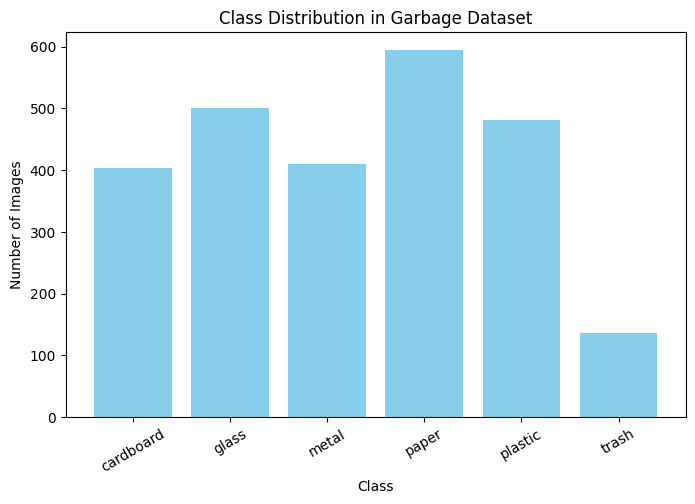

In [9]:
# Generate Class Distribution Chart

# 1. Get class counts
class_counts = [len([label for _, label in train_dataset.samples if label == i]) 
                + len([label for _, label in val_dataset.samples if label == i]) 
                + len([label for _, label in test_dataset.samples if label == i]) 
                for i in range(len(class_names))]

# 2. Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_counts, color='skyblue')
plt.title("Class Distribution in Garbage Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=30)
plt.show()


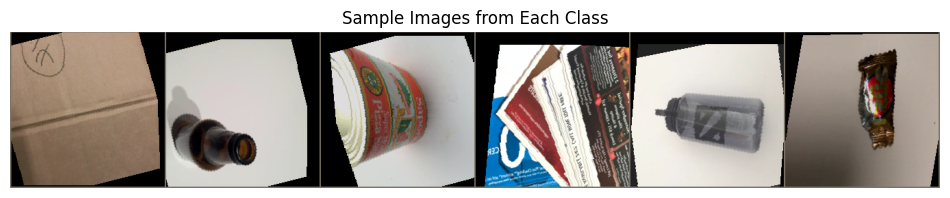

In [10]:
# Display Sample Images from Each Class
from torchvision.utils import make_grid

# Select 1 sample per class from the training dataset
samples = []
for class_idx in range(len(class_names)):
    for img, label in train_dataset:
        if label == class_idx:
            samples.append(img)
            break

# Create a grid of sample images
plt.figure(figsize=(12, 3))
img_grid = make_grid(samples, nrow=len(class_names))
img_grid = img_grid.numpy().transpose((1, 2, 0))

# Unnormalize for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_grid = std * img_grid + mean
img_grid = np.clip(img_grid, 0, 1)

plt.imshow(img_grid)
plt.title("Sample Images from Each Class")
plt.axis('off')
plt.show()


In [11]:
plt.savefig("class_distribution.png", dpi=300)
plt.savefig("sample_images.png", dpi=300)

<Figure size 640x480 with 0 Axes>